# Install and Imports

In [ ]:
!apt-get install -y graphviz
!pip install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
! pip install dowhy
! pip install scikit-learn==1.4.2

In [ ]:
import sklearn
import pandas as pd
import dowhy
from dowhy import CausalModel, gcm
import networkx as nx
import numpy as np
from dowhy.gcm.falsify import FalsifyConst, falsify_graph, plot_local_insights, run_validations, apply_suggestions
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import dowhy.gcm as gcm
from dowhy.gcm.ml import SklearnRegressionModel
from dowhy.gcm import AdditiveNoiseModel, EmpiricalDistribution

# Data Manipulation

In [ ]:
data = pd.read_csv("long_2000_mean_fire_earth_data.csv")
data['temp_C'] = (data['min_temp_C'] + data['max_temp_C'])/2
drop_cols = ['FOD_ID', 'FIRE_NAME', 'DISCOVERY_DATE', 'STAT_CAUSE_DESCR', 'STATE', 'LATITUDE', 'LONGITUDE', 'date', 'dead_fuel_100']
data = data.drop(columns=drop_cols)

# Mapping dictionary
class_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8}

# Apply the mapping
data['FIRE_SIZE_CLASS_NUM'] = data['FIRE_SIZE_CLASS'].map(class_mapping)
data = data.dropna()
data_np = data.to_numpy()

print(data.columns.tolist())

['FIRE_SIZE', 'FIRE_SIZE_CLASS', 'FIRE_YEAR', 'CONT_DATE', 'DURATION_DAYS', 'DISCOVERY_DOY', 'dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C', 'min_temp_C', 'precipitation', 'wind_speed', 'population_density', 'vegetation', 'drought_index', 'temp_C', 'FIRE_SIZE_CLASS_NUM']


In [ ]:
ary_data = data.drop(columns=['dead_fuel_1000',
                              'energy_release',
                              'population_density',
                              'drought_index',
                              'vegetation',
                              #'precipitation',
                              #'wind_speed',
                              'max_temp_C',
                              'min_temp_C',
                              'DISCOVERY_DOY',
                              'CONT_DATE',
                              'DURATION_DAYS',
                              'FIRE_SIZE_CLASS',
                              'FIRE_SIZE',
                              'humidity',
                              ])
ary_data = ary_data.dropna()
ary_data_np = ary_data.to_numpy()
print(ary_data.columns.tolist())

['FIRE_YEAR', 'precipitation', 'wind_speed', 'temp_C', 'FIRE_SIZE_CLASS_NUM']


# Time Based Split

In [ ]:
print(sorted(ary_data['FIRE_YEAR'].unique()))
train_split = ary_data[ary_data['FIRE_YEAR'] < 2014]
test_split = ary_data[ary_data['FIRE_YEAR'] >= 2014]
print(train_split.shape[0]/ary_data.shape[0])
print(test_split.shape[0]/ary_data.shape[0])

[np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015)]
0.8085884514345564
0.1914115485654436


In [ ]:
ary_data = ary_data.drop(columns=['FIRE_YEAR'])
train_split = train_split.drop(columns=['FIRE_YEAR'])
test_split = test_split.drop(columns=['FIRE_YEAR'])

## Model

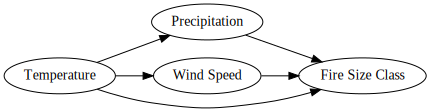

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Define causal graph
causal_graph = nx.DiGraph([

    ('precipitation','FIRE_SIZE_CLASS_NUM'),

    ('wind_speed','FIRE_SIZE_CLASS_NUM'),

    ('temp_C','precipitation'),
    ('temp_C','wind_speed'),
    ('temp_C','FIRE_SIZE_CLASS_NUM'),
])

from graphviz import Digraph

dot = Digraph(format='png')  # or 'pdf' or 'svg'
dot.attr(rankdir='LR')  # Left to right

# Add nodes (labelled nicely)
dot.node('P', 'Precipitation')
dot.node('W', 'Wind Speed')
dot.node('T', 'Temperature')

dot.node('F', 'Fire Size Class')

# Add edges
edges = [
    ('P', 'F'), ('W', 'F'), ('T', 'F'), ('T', 'P'), ('T', 'W')
]

for src, tgt in edges:
    dot.edge(src, tgt)

# Render and display in Colab
dot.render('causal_graph', view=True)  # Will save to file
dot

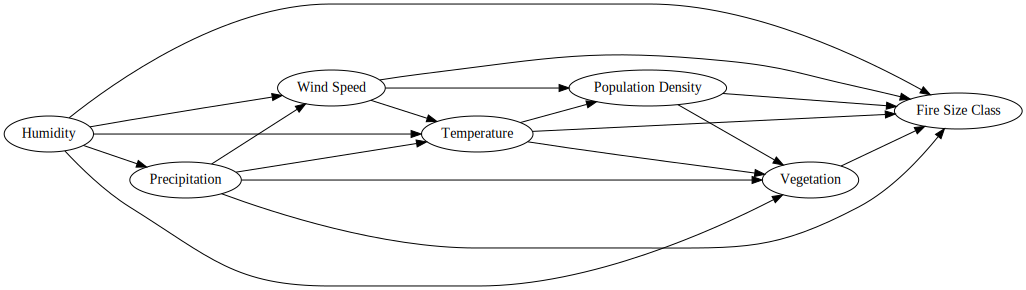

In [27]:
dot = Digraph(format='png')  # or 'pdf' or 'svg'
dot.attr(rankdir='LR')  # Left to right

# Add nodes (labelled nicely)
dot.node('H', 'Humidity')
dot.node('P', 'Precipitation')
dot.node('W', 'Wind Speed')
dot.node('T', 'Temperature')
dot.node('PD', 'Population Density')
dot.node('V', 'Vegetation')
dot.node('F', 'Fire Size Class')

# Add edges
edges = [
    ('H', 'T'), ('H', 'W'), ('H', 'P'), ('H', 'V'), ('H', 'F'),
    ('P', 'W'), ('P', 'T'), ('P', 'V'), ('P', 'F'),
    ('W', 'T'), ('W', 'PD'), ('W', 'F'),
    ('T', 'V'), ('T', 'PD'), ('T', 'F'),
    ('PD', 'V'), ('PD', 'F'),
    ('V', 'F')
]

for src, tgt in edges:
    dot.edge(src, tgt)

# Render and display in Colab
dot.render('causal_graph', view=True)  # Will save to file
dot


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


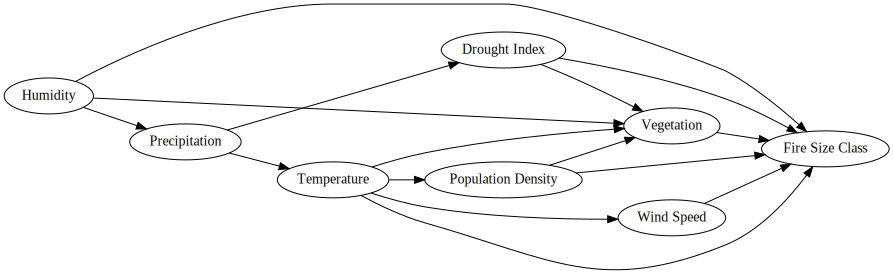

In [28]:
!apt-get install -y graphviz
!pip install graphviz

from graphviz import Digraph

dot = Digraph(format='png')
dot.attr(rankdir='LR')  # Left to right

# Define clean label mapping
labels = {
    'humidity': 'Humidity',
    'precipitation': 'Precipitation',
    'drought_index': 'Drought Index',
    'temp_C': 'Temperature',
    'wind_speed': 'Wind Speed',
    'vegetation': 'Vegetation',
    'population_density': 'Population Density',
    'FIRE_SIZE_CLASS_NUM': 'Fire Size Class'
}

# Add nodes
for var, label in labels.items():
    dot.node(var, label)

# Add edges
edges = [
    ('humidity','FIRE_SIZE_CLASS_NUM'),
    ('humidity', 'vegetation'),
    ('humidity', 'precipitation'),

    ('precipitation','drought_index'),
    ('precipitation','temp_C'),

    ('wind_speed','FIRE_SIZE_CLASS_NUM'),

    ('drought_index','FIRE_SIZE_CLASS_NUM'),
    ('drought_index','vegetation'),

    ('temp_C','FIRE_SIZE_CLASS_NUM'),
    ('temp_C','vegetation'),
    ('temp_C','population_density'),
    ('temp_C','wind_speed'),

    ('vegetation','FIRE_SIZE_CLASS_NUM'),

    ('population_density','FIRE_SIZE_CLASS_NUM'),
    ('population_density','vegetation')
]

for src, tgt in edges:
    dot.edge(src, tgt)

# Render and view
dot.render('causal_graph', view=True)
dot


In [ ]:
# Create causal model
causal_model = gcm.StructuralCausalModel(causal_graph)
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, train_split)
print(auto_assignment_summary)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

Test permutations of given graph: 100%|██████████| 24/24 [00:04<00:00,  5.80it/s]


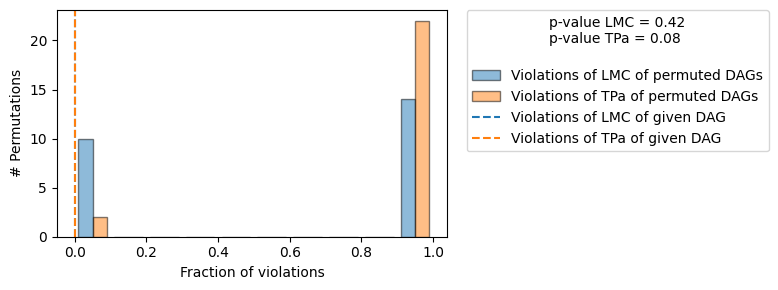

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
# Fit and evaluate
gcm.fit(causal_model, train_split)
evaluation = gcm.evaluate_causal_model(
    causal_model,
    data=test_split
)
print(evaluation)

# Random Split

## Model

In [ ]:
from sklearn.model_selection import train_test_split

train_split, test_split = train_test_split(ary_data, test_size=0.2)

In [ ]:
# Define causal graph
causal_graph = nx.DiGraph([

    ('precipitation','FIRE_SIZE_CLASS_NUM'),

    ('wind_speed','FIRE_SIZE_CLASS_NUM'),

    ('temp_C','precipitation'),
    ('temp_C','wind_speed'),
    ('temp_C','FIRE_SIZE_CLASS_NUM'),
])

In [ ]:
# Create causal model
causal_model = gcm.StructuralCausalModel(causal_graph)
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, train_split)
print(auto_assignment_summary)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

Test permutations of given graph: 100%|██████████| 24/24 [00:03<00:00,  7.67it/s]


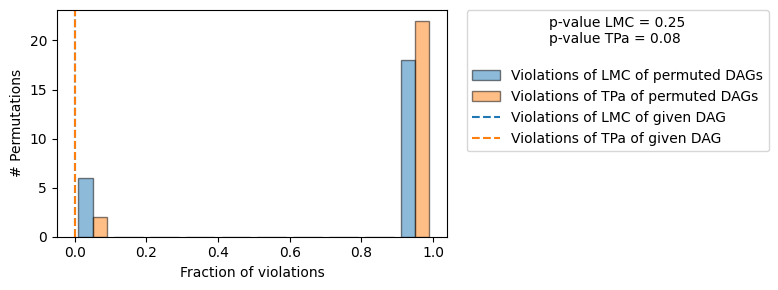

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
# Fit and evaluate
gcm.fit(causal_model, train_split)
evaluation = gcm.evaluate_causal_model(
    causal_model,
    data=test_split
)
print(evaluation)